In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir('/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/sil_consistent_at_inference')
print(os.getcwd())

/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/sil_consistent_at_inference


In [2]:
import pprint
import pickle

import torch
from torch.nn import functional as F
import torch.optim as optim
from tqdm.autonotebook import tqdm
import pandas as pd
import numpy as np

from pose_pred import dataset
from pose_pred.pose_pred_network import PoseNetwork

# Setup

In [3]:
class_name = "03001627"
#class_name = "02691156"
batch_size = 32
epochs = 100
lr = 0.00001
weight_decay = 0.0


#input_mesh_dir = "../occupancy_networks/out/pytorch3d_renders_training/{}/generation/meshes".format(class_name)
input_img_dir = "data/input_images/pytorch3d_shapenet_renders_training/{}/rgba".format(class_name)
pose_path = "../occupancy_networks/out/pytorch3d_renders_training/{}/generation/meshes/rec_camera_params.pt".format(class_name)
train_partition_file = "data_prep_tools/adv_refine_training_partitions/{}_train.lst".format(class_name)
val_partition_file = "data_prep_tools/adv_refine_training_partitions/{}_val.lst".format(class_name)

cfg = {"input_img_dir":input_img_dir, "pose_path": pose_path, "train_partition_file":train_partition_file,  "val_partition_file":val_partition_file}
device = torch.device("cuda:0")

In [7]:
with open(cfg["train_partition_file"], 'r') as f:
    train_partition_instances = f.read().split('\n')
training_dataset = dataset.PosePredDataset(cfg, train_partition_instances)
training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, num_workers=2, shuffle=True, drop_last=True)

with open(cfg["val_partition_file"], 'r') as f:
    val_partition_instances = f.read().split('\n')
val_dataset = dataset.PosePredDataset(cfg, val_partition_instances)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=2, shuffle=False, drop_last=True)

Filtered based on specified instances, from 6778 -> 4339.
Filtered based on specified instances, from 6778 -> 1084.


In [4]:
pose_net = PoseNetwork(cfg, device).to(device)
optimizer = optim.Adam(pose_net.parameters(), lr=lr, weight_decay=weight_decay)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


# Training Weights

In [5]:
load_model_weights_path = "notebooks/pose_net_weights_100_03001627.pt"
pose_net.load_state_dict(torch.load(load_model_weights_path))

<All keys matched successfully>

In [6]:
training_df = pd.DataFrame()
val_df = pd.DataFrame()
for epoch_idx in tqdm(range(epochs)):
    for batch_i, batch in enumerate(tqdm(training_dataloader)):
        optimizer.zero_grad()
        pose_net.train()
        
        pred_pose = pose_net(batch)
        
        gt_pose = batch["pose"].to(device)
        loss = F.mse_loss(pred_pose, gt_pose)
        loss.backward()
        optimizer.step()
        
        curr_df_dict = {"epoch":epoch_idx+(batch_i/len(training_dataloader)), "loss":loss.item()}
        training_df = training_df.append(curr_df_dict, ignore_index=True)
    
    
    # evaluating on validation set
    with torch.no_grad():
        avg_val_loss = 0.0
        for batch_i, batch in enumerate(tqdm(val_dataloader)):
            pose_net.eval()
            pred_pose = pose_net(batch)
        
            gt_pose = batch["pose"].to(device)
            loss = F.mse_loss(pred_pose, gt_pose)
            avg_val_loss += loss.item()
        avg_val_loss = avg_val_loss / len(val_dataloader)
        curr_val_df_dict = {"epoch":epoch_idx, "loss":avg_val_loss}
        val_df = val_df.append(curr_val_df_dict, ignore_index=True)

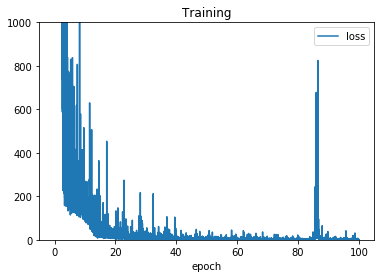

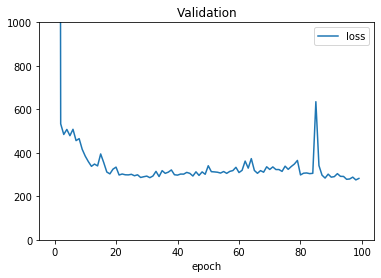

In [9]:
upper_lim = 1000
training_df.plot.line(x="epoch", y="loss", ylim=[0,upper_lim], title="Training")
val_df.plot.line(x="epoch", y="loss", ylim=[0,upper_lim], title="Validation")

In [10]:
save_model_weights_path = "notebooks/pose_net_weights_{}_{}.pt".format(epochs,class_name)
torch.save(pose_net.state_dict(), save_model_weights_path)

# Eval

In [8]:
torch.set_printoptions(sci_mode=False)
with torch.no_grad():
    for batch_i, batch in enumerate(training_dataloader):
        pose_net.eval()
        pred_pose = pose_net(batch)

        gt_pose = batch["pose"].to(device)
        print(pred_pose[:4,:])
        print(gt_pose[:4,:])
        break

tensor([[ 99.0981,  39.6900,   1.3216],
        [ 82.2067,  39.6091,   1.3254],
        [167.5791,  39.5387,   1.3735],
        [206.8150,  39.6395,   1.3856]], device='cuda:0')
tensor([[ 98.9532,  40.0000,   1.5897],
        [ 82.4373,  40.0000,   1.1410],
        [170.3733,  40.0000,   1.2692],
        [209.8812,  40.0000,   1.4615]], device='cuda:0')


In [9]:
azim_differences = []
elev_differences = []

with torch.no_grad():
    for batch_i, batch in enumerate(tqdm(val_dataloader)):
        pose_net.eval()
        pred_pose = pose_net(batch)

        gt_pose = batch["pose"].to(device)
        pred_pose_offsets = torch.abs(gt_pose-pred_pose)
        azim_differences.append(pred_pose_offsets[:,0].detach().cpu())
        elev_differences.append(pred_pose_offsets[:,1].detach().cpu())
        
            
azim_differences = torch.cat(azim_differences).numpy()
elev_differences = torch.cat(elev_differences).numpy()

In [10]:
print("mean azim offset: {} +/- {}".format(np.mean(azim_differences), np.std(azim_differences)))
print("mean elev offset: {} +/- {}".format(np.mean(elev_differences), np.std(elev_differences)))

mean azim offset: 8.589871406555176 +/- 27.796689987182617
mean elev offset: 0.569574773311615 +/- 0.31481361389160156
